In [5]:
!pip install mxnet-cu112
!pip install gluoncv

In [1]:
%matplotlib inline

# Uncomment and edit these commands depending on required versions...
# ... may need to uninstall current versions

# !pip install mxnet-cu112
# !pip install gluoncv

import os 
import yaml
import numpy as np
import mxnet as mx
import json
import boto3
import cv2
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
from collections import namedtuple
from pathlib import Path
from itertools import product
from random import seed, shuffle
from tqdm import tqdm
from gluoncv import data as gdata
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet import gluon
os.chdir('..')

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [10]:
%%time
    
def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))
        
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx
ctx = get_ctx()[0]
print(ctx)
TMP_FOLDER = "Users/Ben.Bradshaw/bird-counting-master/bird-counting-master/models/detection/weights"# './models/detection/weights'
make_tmp_folder(TMP_FOLDER)

Batch = namedtuple('Batch', ['data'])

CLASSES = ['bird']
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.1

cpu(0)
CPU times: user 1.9 ms, sys: 5.27 ms, total: 7.17 ms
Wall time: 538 ms


In [11]:
from gluoncv import model_zoo
import mxnet as mx
import numpy as np# Download the model from the Gluon model zoo
# You'll find it in ~/.mxnet/models
net = model_zoo.get_model('ssd_512_resnet50_v1_custom', pretrained=False, classes=['bird'])# Convert the model to symbolic format
net.initialize(force_reinit=True)
net.load_parameters(f"{TMP_FOLDER}/best.params")
os.getcwd()
# net.hybridize()# Build a fake image to run a single prediction
# # # This is required to initialize the model properly
# x = np.zeros([1,3,224,224])
# x = mx.nd.array(x)# Predict the fake image
# net.forward(x)# Export the model
# net.export(f'{TMP_FOLDER}/best-model')

net.collect_params().reset_ctx(ctx=[mx.gpu(0)])

MXNetError: Traceback (most recent call last):
  File "../3rdparty/dmlc-core/src/io/local_filesys.cc", line 209
LocalFileSystem: Check failed: allow_null: :Open "Users/Ben.Bradshaw/bird-counting-master/bird-counting-master/models/detection/weights/best.params": No such file or directory

In [30]:
# Make sure to swap ../mxnet-ssd/deploy.py for your local path to mxnet-ssd/deploy.py
!export MXNET_CUDNN_LIB_CHECKING=0 && export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1 && python ./mxnet-ssd/deploy.py --network resnet50 --num-class 1 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/best-model

param_path=os.path.join(TMP_FOLDER, 'deploy_best-model')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True, allow_extra=True)

Saved model: ./models/detection/weights/deploy_best-model-0000.params
Saved symbol: ./models/detection/weights/deploy_best-model-symbol.json
param_path: ./models/detection/weights/deploy_best-model


In [20]:
def ensure_path(path: str) -> Path:
    path = Path(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

class Tiler():
    def __init__(self, w=8192, h=5460, dw=512, dh=546, stride=1):
        self.w = w
        self.h = h
        self.dw = dw
        self.dh = dh
        self.stride = stride
        self.offset = (self.dw*self.stride, self.dh*self.stride)
        self.cols = int(np.ceil(self.w / self.offset[0]))
        self.rows = int(np.ceil(self.h / self.offset[1]))
        
    def get_tile_dict(self):
        
        tile_dict = {}
        for col, row in product(range(self.cols), range(self.rows)):
            top = int(self.offset[1]*row)
            bottom = top + self.dh
            left = int(self.offset[0]*col)
            right = left + self.dw
            
            tile_dict[(col,row)] = (top, bottom, left, right)
        return tile_dict
    
    def get_tile_id_from_point(self, tile_dict, point):
        step = int(1/self.stride)
        x = point['x']
        y = point['y']
        
        id_x1 = int(np.floor(x/self.offset[0]))
        id_x1 = id_x1 if not id_x1 == self.cols else self.cols-1
        id_y1 = int(np.floor(y/self.offset[1]))
        id_y1 = id_y1 if not id_y1 == self.rows else self.rows-1
        id_1 = (id_x1, id_y1)
        
        return id_1

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]

    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

In [31]:
with open('./params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)
    raw_dir = Path(params['data']['raw_dir'])

points_path = raw_dir / 'Points_25Nov_01_FINAL.pnt'
with open(points_path) as file:
    data = file.read()
    data = json.loads(data)
    points_dict = data.get('points')
    
tl = Tiler()
tile_dict = tl.get_tile_dict()

nonempty_tile_dict = {}
tile_count = 0
for img_id, coords_dict in points_dict.items():
    tile_list = []
    for _, pts in coords_dict.items():
        for pt in pts:
#             import ipdb; ipdb.set_trace()
            tile_id = tl.get_tile_id_from_point(tile_dict, pt)
            tile_list.append(tile_id)
    tile_set = set(tile_list)
    tile_count += len(tile_set)
    if tile_set:
        nonempty_tile_dict[img_id] = tile_set
print(tile_count)

nonempty_ids = list(nonempty_tile_dict.keys())
nonempty_ids = [int(os.path.splitext(id.split("_")[2])[0]) for id in nonempty_ids]
print(len(nonempty_ids))
seed(1)
shuffle(nonempty_ids)
hold_ids = nonempty_ids[:17]
rem_ids = nonempty_ids[17:]

count_dict = {}
for img_id, data in points_dict.items():
    c1 = 0
    c2 = 0
    if data.get('Nesting'):
        c1 = len(data.get('Nesting'))
    if data.get('Flying'):
        c2 = len(data.get('Flying'))
    count_dict[img_id] = c1+c2

2744
117


In [9]:
!cat $TMP_FOLDER/hyperparams.json

cat: ./models/detection/weights/hyperparams.json: No such file or directory


In [11]:
%%time
VALIDATION_IMAGE_FOLDER = '../data/nonempty-slices/holdout-inference'
make_tmp_folder(VALIDATION_IMAGE_FOLDER)
img_list = os.listdir(VALIDATION_IMAGE_FOLDER)
output_file = '../results/latest-model/all-holdout-inference-results.json'
with open(output_file, "w") as outfile:
    for img in tqdm(img_list):
        if img.endswith("jpg"):
            result,_orig = infer(os.path.join(VALIDATION_IMAGE_FOLDER, img))
            to_write = {"image": img, "prediction": result.tolist()}
            outfile.write(json.dumps(to_write))
            outfile.write('\n')

../data/nonempty-slices/holdout-inference folder already exists
CPU times: user 1.98 ms, sys: 8.1 ms, total: 10.1 ms
Wall time: 8.95 ms


In [ ]:
def count_raw(file_points_dict, bbox):
    c = 0
    for pose, data in file_points_dict.items():
        for point in data:
            x = point['x']
            y = point['y']
            if l<x<r and t<y<b:
                c+=1
    return c

with open('./params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)
    raw_dir = Path(params['data']['raw_dir'])

points_path = raw_dir / 'Points_25Nov_01_FINAL.pnt'

with open(points_path) as file:
    data = file.read()
    data = json.loads(data)
    points_dict = data.get('points')

In [223]:
# print(os.chdir('..'))
# test_lists = ['./training/labels/val.lst']
# test_lists = ['./training/labels/train.lst']
test_lists = ['./training/labels/test005.lst','./training/labels/test007.lst','./training/labels/test011.lst','./training/labels/test015.lst',
              './training/labels/test021.lst','./training/labels/test034.lst','./training/labels/test037.lst','./training/labels/test040.lst',
              './training/labels/test047.lst','./training/labels/test078.lst','./training/labels/test109.lst','./training/labels/test113.lst',
              './training/labels/test124.lst','./training/labels/test137.lst','./training/labels/test190.lst','./training/labels/test200.lst',
              './training/labels/test201.lst']
all_pr_counts = 0
all_gt_counts = 0
for test_list in test_lists:
    val_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_dataset = gdata.LstDetection(root='', filename=test_list)
    batch_size=16

    val_loader = gluon.data.DataLoader(
            val_dataset.transform(SSDDefaultTrainTransform(512, 512)),
            batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep', num_workers=4)

    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=400)
    net.hybridize(static_alloc=True, static_shape=True)
    i = 0
    pr_counts = 0
    for batch in tqdm(val_loader):
        data = gluon.utils.split_and_load(batch[0], ctx_list=[mx.gpu()], batch_axis=0, even_split=True)
        label = gluon.utils.split_and_load(batch[1], ctx_list=[mx.gpu()], batch_axis=0, even_split=True)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            ids, scores, bboxes = net(x)
            np_scores = np.array([score.asnumpy()[0] for score in scores[0]])
            pr_counts+=len(np_scores[np_scores>0.49])*batch_size

    with open(test_list,'r') as fr:
        data = fr.readlines()
    samples = []
    gt_counts = 0
    for datum in data:
        filename = os.path.basename(datum.split('\t')[-1].replace('\n',''))
        slice_bbox = filename.split('_')[-4:]
        slice_bbox = [int(os.path.splitext(elem[1:])[0]) for elem in slice_bbox]
        t,b,l,r = slice_bbox
        sample = {
            'filename': filename,
            'slice_box': slice_bbox
        }
        samples.append(sample)
        raw_file = '_'.join(filename.split('_')[:3])+'.JPG'
        gt_count = count_raw(points_dict[raw_file], slice_bbox)
        gt_counts+=gt_count
    #     import ipdb; ipdb.set_trace()
    print(f"Ground truth counts: {gt_counts}")
    print(f"Predicted counts: {pr_counts}")
    print(f"Percentage for image {os.path.splitext(os.path.basename(test_list))[0][4:]}: {round(100*pr_counts/gt_counts,2)}")
    all_gt_counts+=gt_counts
    all_pr_counts+=pr_counts
print(f"Total ground truth counts: {all_gt_counts}")
print(f"Total predicted counts: {all_pr_counts}")
print(f"Overall Percentage is: {round(100*all_pr_counts/all_gt_counts,2)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]

Ground truth counts: 545
Predicted counts: 928
Percentage for image 005: 170.28



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]

Ground truth counts: 470
Predicted counts: 1216
Percentage for image 007: 258.72



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]

Ground truth counts: 171
Predicted counts: 352
Percentage for image 011: 205.85



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]

Ground truth counts: 263
Predicted counts: 864
Percentage for image 015: 328.52



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]

Ground truth counts: 233
Predicted counts: 656
Percentage for image 021: 281.55



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]

Ground truth counts: 1313
Predicted counts: 2176
Percentage for image 034: 165.73



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]

Ground truth counts: 1267
Predicted counts: 2736
Percentage for image 037: 215.94



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]

Ground truth counts: 195
Predicted counts: 592
Percentage for image 040: 303.59



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]

Ground truth counts: 1
Predicted counts: 416
Percentage for image 047: 41600.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]

Ground truth counts: 1807
Predicted counts: 1984
Percentage for image 078: 109.8



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]

Ground truth counts: 1
Predicted counts: 336
Percentage for image 109: 33600.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]

Ground truth counts: 2094
Predicted counts: 2080
Percentage for image 113: 99.33



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]

Ground truth counts: 1
Predicted counts: 320
Percentage for image 124: 32000.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]

Ground truth counts: 3
Predicted counts: 384
Percentage for image 137: 12800.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]

Ground truth counts: 1
Predicted counts: 336
Percentage for image 190: 33600.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]

Ground truth counts: 3
Predicted counts: 384
Percentage for image 200: 12800.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]

Ground truth counts: 5
Predicted counts: 384
Percentage for image 201: 7680.0
Total ground truth counts: 8373
Total predicted counts: 16144
Overall Percentage is: 192.81


In [32]:
%%time
from gluoncv.data.transforms.presets.ssd import load_test
from gluoncv import model_zoo, data, utils

# prediction_image = 'DJI_20210928101631_0007_t0000_b0546_l6656_r7168.jpg'
# prediction_path = f'/media/polydatum/Seagate/dev/bird-counting/data/slices-trainval/DJI_202109281012_017_Mid_Lake_1010_70m_D2_50mm_10-lap/sliced_images/{prediction_image}'
prediction_image = "DJI_20210928101623_0003_t4914_b5460_l7168_r7680.jpg"
prediction_path = f"./data/slices-trainval/DJI_202109281012_017_Mid_Lake_1010_70m_D2_50mm_10-lap/sliced_images/{prediction_image}"

results, org_image = infer(prediction_path)
results[:, (2, 4)] *= SHAPE
results[:, (3, 5)] *= SHAPE
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), facecolor='white', dpi=100)
axis=axes

ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
# plt.savefig(os.path.splitext('../results/latest-model/outputs/'+prediction_image)[0]+'_inference.jpg')
# from mxnet import image
# x, img = load_test(prediction_path, short=512)

# from PIL import Image
# from skimage.transform import resize

# image = mx.ndarray.array(resize(img.astype(np.uint8), (512,512,3)))
# type(image)
# image = transform_test(image, ctx)
# class_IDs, scores, bounding_boxes = net(x)


# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams.update({'font.size': 25})
# ax = utils.viz.plot_bbox(image, bounding_boxes[0], scores[0],
#                          class_IDs[0], class_names=net.classes)
plt.show()

NameError: name 'infer' is not defined

In [8]:
folder = "../data/nonempty-slices/holdout-inference"
files = os.listdir(folder)

for prediction_image in tqdm(files):
    if '_0201_' in prediction_image:
        prediction_path = f'{folder}/{prediction_image}'
        results, org_image = infer(prediction_path)
        results[:, (2, 4)] *= SHAPE
        results[:, (3, 5)] *= SHAPE
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), facecolor='white', dpi=100)
        axis=axes

        ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
        plt.savefig(os.path.splitext('../results/latest-model/outputs/'+prediction_image)[0]+'_inference.jpg')
        # Clear the current axes.
        plt.cla() 
        # Clear the current figure.
        plt.clf() 
        # Closes all the figure windows.
        plt.close('all')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2720/2720 [01:16<00:00, 35.47it/s]


In [12]:
val_results = {}
with open(output_file, 'r') as f:
    data = f.readlines()
    for datum in data:
        temp = json.loads(datum.replace('\n',''))
        img_id = temp['image'].split('_')[2]
        if val_results.get(img_id):
            val_results[img_id] += len(temp['prediction'])
        else:
            val_results[img_id] = len(temp['prediction'])

In [13]:
hold_results = {}
for id in hold_ids:
    key = f"{id:04d}"
    value = val_results[f"{id:04d}"]
    hold_results[key] = value

In [14]:
xs = []
ys = []
for key, value in count_dict.items():
    img_id = os.path.splitext(key.split('_')[2])[0]
    if hold_results.get(img_id):
        xs.append(value)
        ys.append(hold_results[img_id])

# xs.extend([
xs = np.array(xs)
ys = np.array(ys)
xs_fit = xs[:,np.newaxis]

a, res, _, _ = np.linalg.lstsq(xs_fit, ys, rcond=None)
r2 = 1 - res / (ys.size * ys.var())
a,r2

(array([0.94724793]), array([0.99221081]))

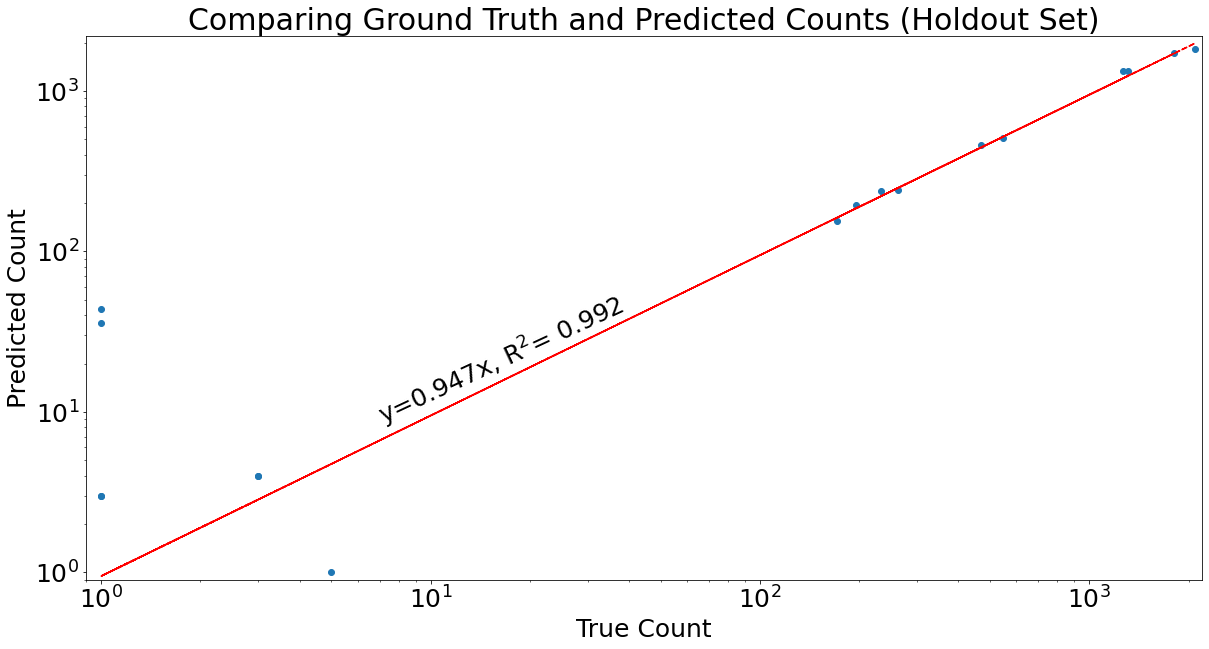

In [21]:
import matplotlib.pyplot as plt
import pylab
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 25})

# pylab.plot(xs,ys,'o')
# pylab.plot(xs,a*xs,"r--")
pylab.loglog(xs,ys,'o')
pylab.loglog(xs,a*xs,"r--")
plt.xlim(0.9,2200)
plt.ylim(0.9,2200)
plt.ylabel('Predicted Count')
plt.xlabel('True Count')
plt.title('Comparing Ground Truth and Predicted Counts (Holdout Set)')
plt.text(np.log(800), np.log(4000), f"y={a[0]:.3f}x," + " $\mathregular{R^{2}}$" + f"= {r2[0]:0.3f}", rotation = 25)
plt.text(650, 670, f"y={a[0]:.3f}x," + " $\mathregular{R^{2}}$" + f"= {r2[0]:0.3f}", rotation = 25)
plt.savefig("../results/latest-model/loglog_latestmodel_comparing_true_vs_predicted_counts.png")
plt.savefig("../results/latest-model/linear_latestmodel_comparing_true_vs_predicted_counts.png")

In [ ]:
maxn = np.max(list(count_dict.values()))
results = {}
for key, x in count_dict.items():
    img_id = os.path.splitext(key.split('_')[2])[0]
    if hold_results.get(img_id):
        y = hold_results[img_id]
        results[img_id] = {'x': x, 'y': y, '%': float(f"{(x+y)/(y+maxn)*200*(y-x)/(x+y):0.02f}")}
results